# Heart attack prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Goal

#### Current Cost

The goal of this project is to reduce the costs associated to heart attacks in the national healthcare system by a 20%. The current cost per person is:

$$ Current cost = (1-HA) * (CostNHA) + HA * (CostHA) = 4709.3€ $$

$$ Current cost = 0.905799 * 0 + 0.094186 * 50000 = 4709.3€ $$

HA = Heart attack probability = 0.094186

CostHA = Cost of one person having a heart attack = 50000

CostNHA = Cost of one person not having a heart attack = 0

#### After plan cost

The cost per person after applying this program has several branches:
* People that won't have a HA but were diagnosed to have one and accept to follow the plan -> Cost: 1.000€
$$ C1 = FPP * 1.000€ $$

* People that will have a heart attack but were diagnosed not to have one -> Cost: 50.000€
$$ C2 = FNP * 50.000€ $$

* People that will have a heart attack, are diagnosed to have one and decide not to take the plan -> Cost: 50.000€
$$ C3 = TPP * (1- P(takesplan)) * 50.000€ $$

* People that will have a heart attack, are diagnosed to have one and decide to take the plan, and they don't adhere to it -> Cost: 51.000€
$$ C4 = TPP * P(takesplan) * (1-P(adheresplan)) * 51.000€ $$

* People that will have a heart attack, are diagnosed to have one and decide to take the plan, they adhere to it, and it doesn't work -> Cost: 51.000€
$$ C5 = TPP * P(takesplan) * P(adheresplan) * (1-P(planworks)) * 51.000€ $$

* People that will have a heart attack, are diagnosed to have one and decide to take the plan, they adhere to it, and it works -> Cost: 1.000€
$$ C6 = TPP * P(takesplan) * P(adheresplan) * P(planworks) * 1.000€ $$

FPP = False Positive Percentage = TN / Total Cases

FNP = False Negative Percentage = FN / Total Cases

TPP = True Positive Percentage = TP / Total Cases

P(takesplan) = Probability that someone takes the plan when is offered to him/her = 0.85

P(adheresplan) = Probability that someone adheres to the plan = Unknown

P(planworks) = Probability that the plan works = 0.75

#### Formula
We need to do a cost analysis to check the minimum percentage of adherence that we need in order to reduce the cost by 20%, that means, we need to get the value of P(adheresplan) so that the cost is equal than 80% of the current cost.

$$ Currentcost * 0.8 = Newcost $$
$$ Currentcost * 0.8 - (c1 + c2 + c3) = c4 + c5 + c6 $$

$$ (Currentcost * 0.8 - (c1 + c2 + c3)) / (TPP*P(takesplan)) = $$
$$ =((1-P(adheresplan))*51000) + (P(adheresplan)*(1-(P(planworks))*51000) + (P(adheresplan)*P(planworks)*1000) = $$
$$ = 51000-51000*P(adheresplan) + P(adheresplan)*(1-P(planworks))*51000) + (P(adheresplan)*P(planworks)*1000) $$

$$ ((Currentcost * 0.8 - (c1 + c2 + c3)) / (TPP*P(takesplan)) - 51000)/ P(adheresplan) = $$
$$ = -51000 + (1-P(planworks))*51000) + P(planworks)*1000) $$

$$ P(adheresplan) = $$
$$ = ((Currentcost * 0.8 - (c1 + c2 + c3)) / (TPP*P(takesplan)) - 51000)/ (-51000 + (1-P(planworks))*51000) + P(planworks)*1000)) = $$
$$ = ((Currentcost * 0.8 - (c1 + c2 + c3)) / (TPP*P(takesplan)) - 51000)/ (-P(planworks))*51000) + P(planworks)*1000))$$
$$ = ((Currentcost * 0.8 - (c1 + c2 + c3)) / (TPP*P(takesplan)) - 51000)/ (-P(planworks))*50000)))$$


In [262]:
def minimum_adheresplan_prob(total_cases, heart_attacks, fpp, fnp, tpp, p_takesplan=0.85, p_planworks=0.75):
    ha = heart_attacks/total_cases
    nha = 1-ha
    
    current_cost = ha*50000 + nha*0
    target_new_cost = 0.8 * current_cost
    
    #print(f"We need a to reduce the cost per person to {target_new_cost}€\n")
    
    c1 = fpp * 1000
    c2 = fnp * 50000
    c3 = tpp * (1-p_takesplan) * 50000
    
    p_adheresplan = (((target_new_cost - (c1+c2+c3)) / (tpp*p_takesplan)) - 51000) / (-p_planworks*50000)
    
    #print(f"The minimum adherence rate plan to reduce the cost by 20% is {p_adheresplan}\n")
    
    return p_adheresplan #if p_adheresplan > 0 and p_adheresplan < 1 else None

## Load the dataset 

In [3]:
df = pd.read_csv("heart_disease.csv")

### Data exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   HeartAttack        253676 non-null  float64
 1   HighBP             253679 non-null  float64
 2   HighChol           253679 non-null  float64
 3   CholCheck          253679 non-null  float64
 4   BMI                253679 non-null  float64
 5   Smoker             253679 non-null  float64
 6   Stroke             253679 non-null  float64
 7   Diabetes           253680 non-null  float64
 8   PhysActivity       253680 non-null  float64
 9   Fruits             253679 non-null  float64
 10  Veggies            253679 non-null  float64
 11  HvyAlcoholConsump  253679 non-null  float64
 12  GenHlth            253680 non-null  float64
 13  MentHlth           253679 non-null  float64
 14  PhysHlth           253680 non-null  float64
 15  DiffWalk           253680 non-null  float64
 16  Se

In [5]:
df.HeartAttack.value_counts()

0.0    229783
1.0     23893
Name: HeartAttack, dtype: int64

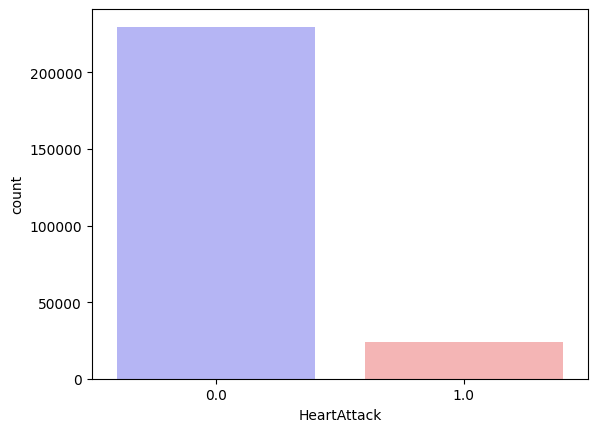

In [6]:
sns.countplot(x="HeartAttack", data=df, palette="bwr")
plt.show()

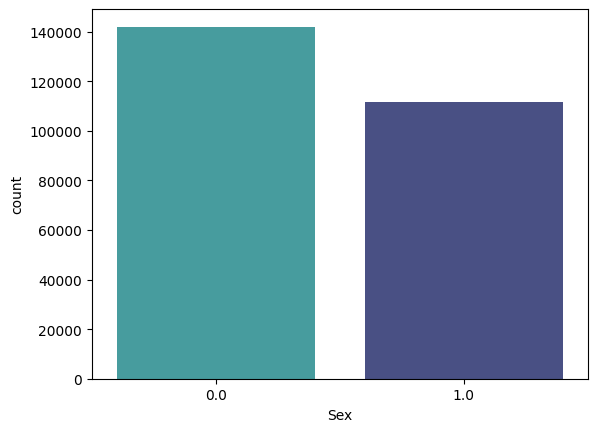

In [7]:
sns.countplot(x='Sex', data=df, palette="mako_r")
plt.show()

In [8]:
df.groupby('HeartAttack').mean()
# not sure how this adds value

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
HeartAttack,,,,,,,,,,,,,,,,,,,
0.0,0.395592,0.395331,0.959966,28.270060,0.424833,0.027657,0.256342,0.768630,0.637326,0.816356,0.058347,2.422359,3.030094,3.731329,0.142565,0.426559,7.813716,5.082116,6.148035
1.0,0.750345,0.701168,0.988658,29.466622,0.619470,0.164776,0.687231,0.640355,0.604696,0.763906,0.035492,3.367555,4.670322,9.154439,0.414975,0.572887,10.131210,4.745971,5.148161


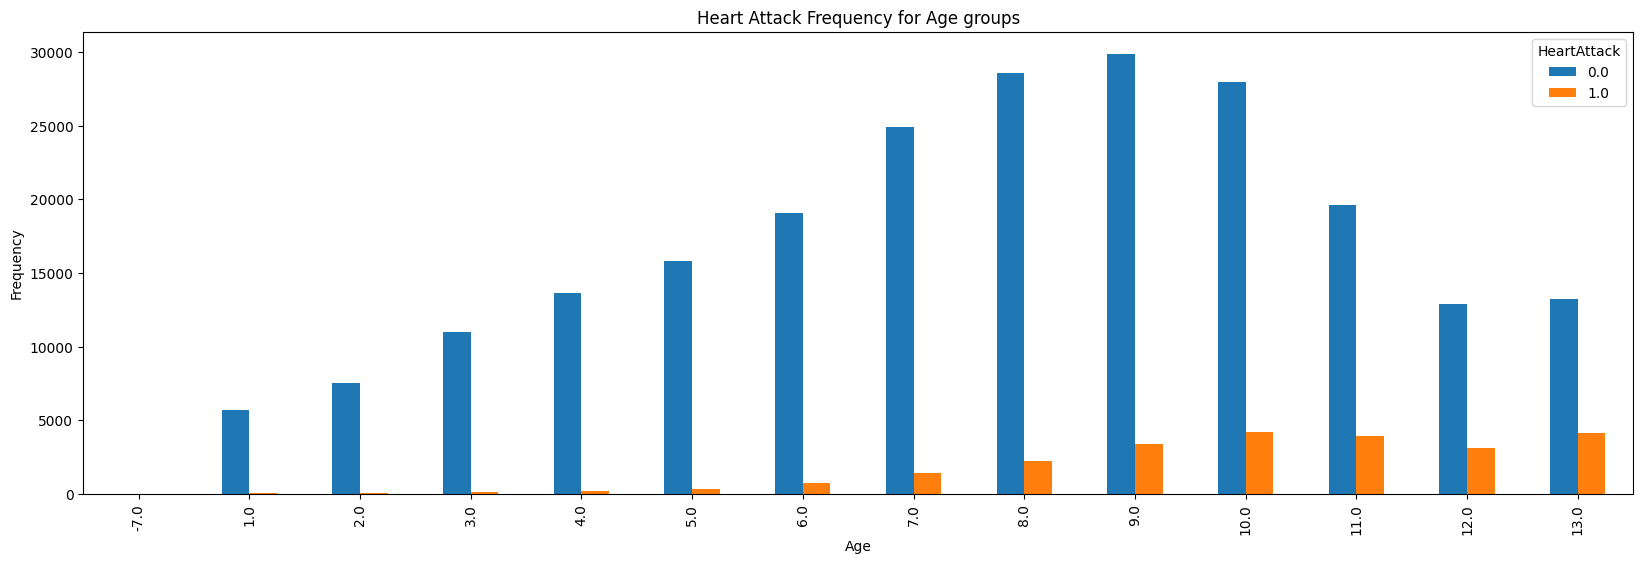

In [9]:
pd.crosstab(df.Age,df.HeartAttack).plot(kind="bar",figsize=(20,6))
plt.title('Heart Attack Frequency for Age groups')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

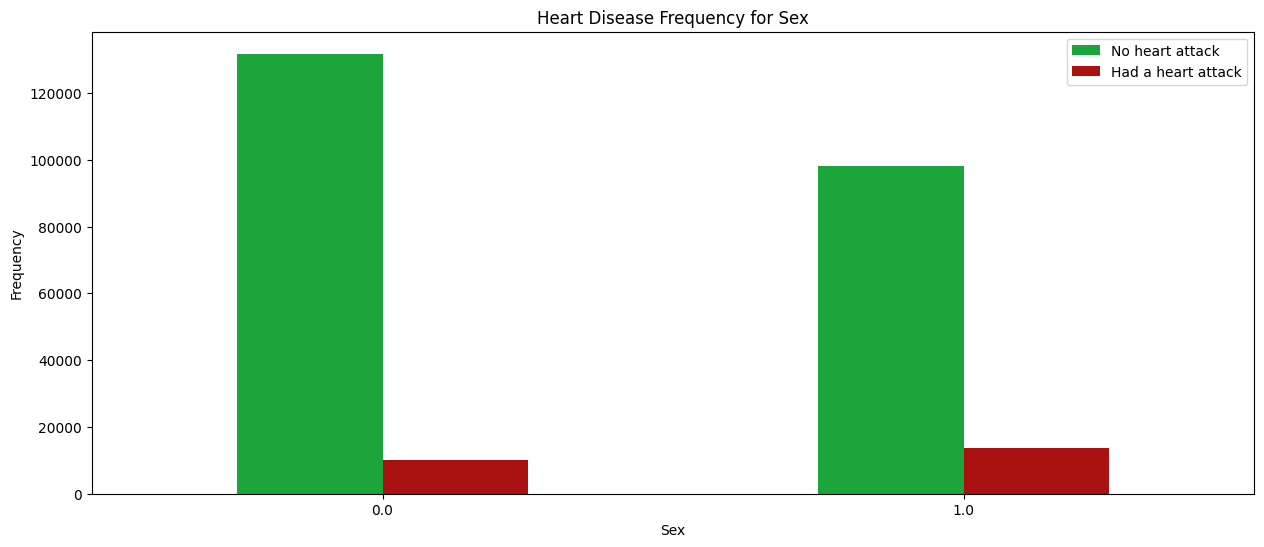

In [10]:
pd.crosstab(df.Sex,df.HeartAttack).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex')
plt.xticks(rotation=0)
plt.legend(["No heart attack", "Had a heart attack"])
plt.ylabel('Frequency')
plt.show()

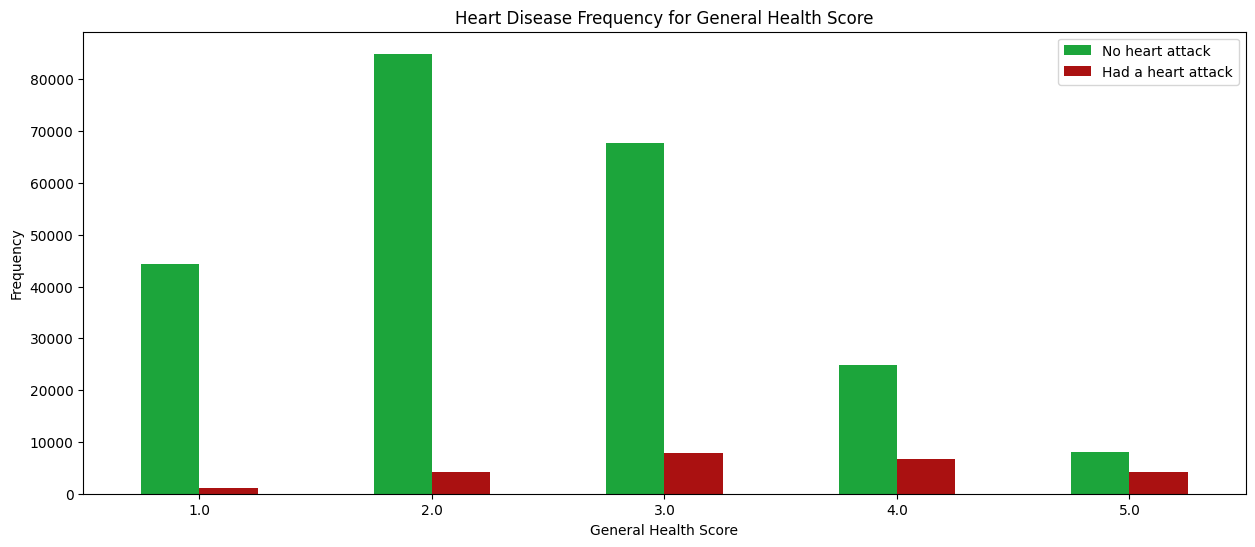

In [11]:
pd.crosstab(df.GenHlth,df.HeartAttack).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for General Health Score')
plt.xlabel('General Health Score')
plt.xticks(rotation=0)
plt.legend(["No heart attack", "Had a heart attack"])
plt.ylabel('Frequency')
plt.show()

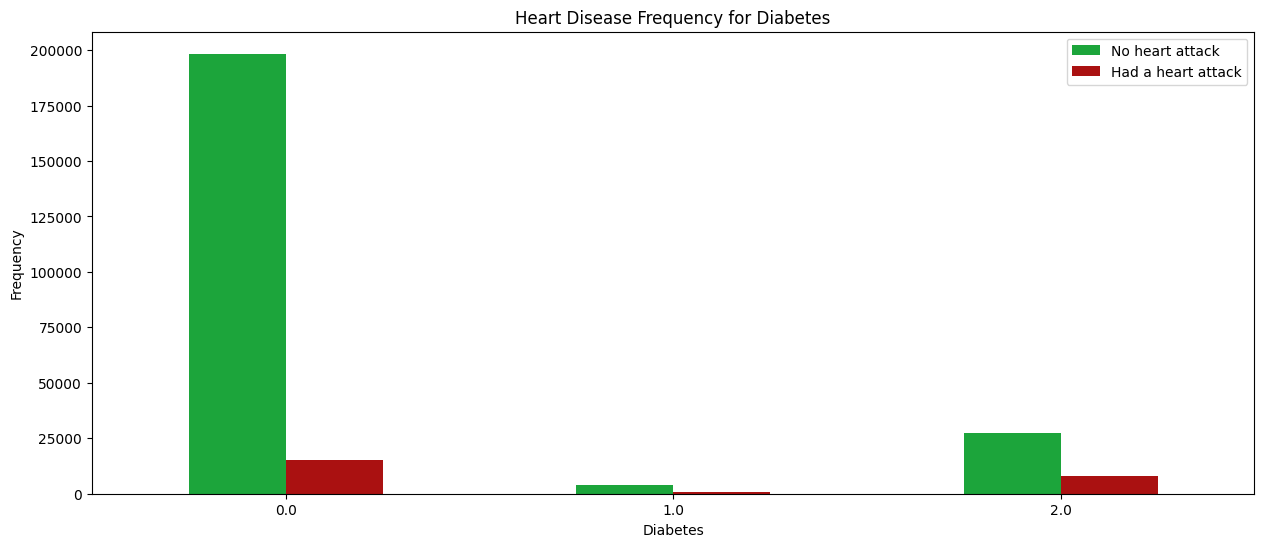

In [12]:
pd.crosstab(df.Diabetes,df.HeartAttack).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Diabetes')
plt.xlabel('Diabetes')
plt.xticks(rotation=0)
plt.legend(["No heart attack", "Had a heart attack"])
plt.ylabel('Frequency')
plt.show()

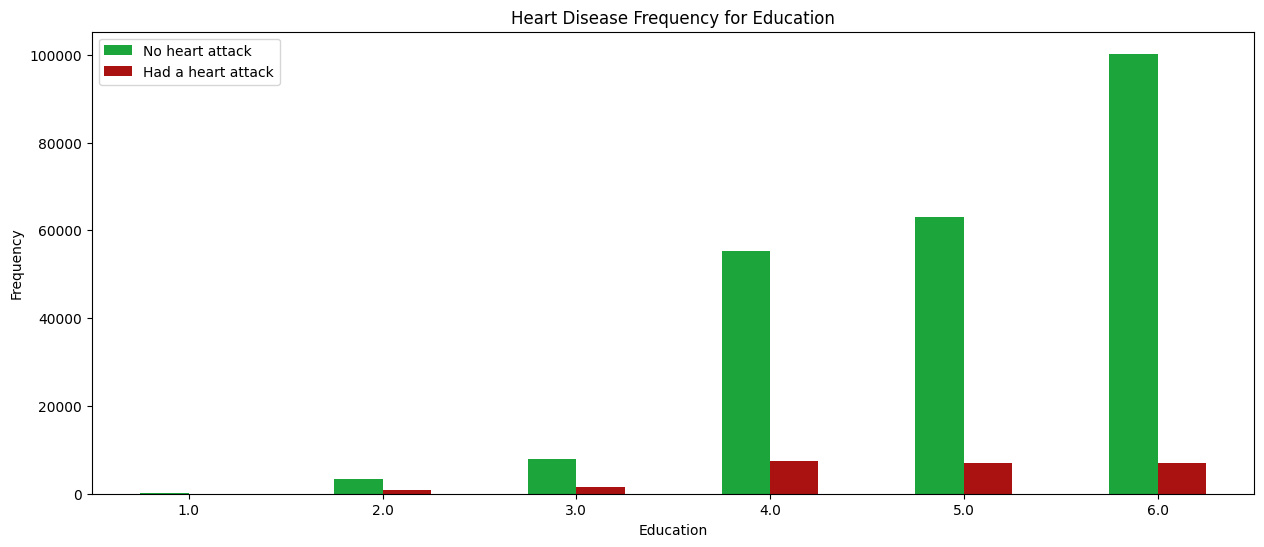

In [13]:
pd.crosstab(df.Education,df.HeartAttack).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Education')
plt.xlabel('Education')
plt.xticks(rotation=0)
plt.legend(["No heart attack", "Had a heart attack"])
plt.ylabel('Frequency')
plt.show()

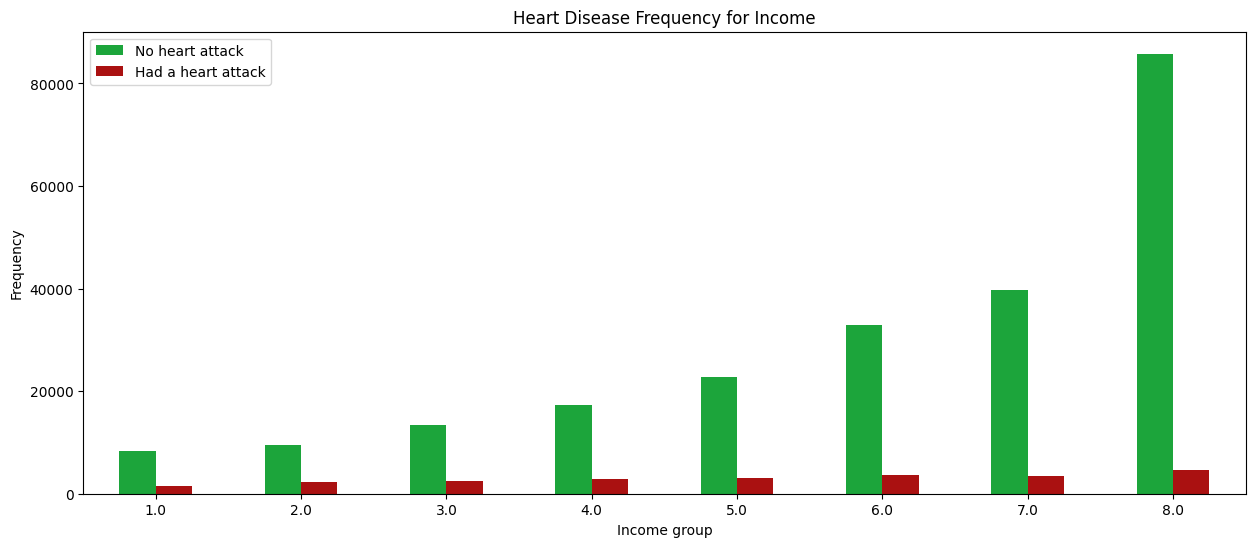

In [14]:
pd.crosstab(df.Income,df.HeartAttack).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111' ])
plt.title('Heart Disease Frequency for Income')
plt.xlabel('Income group')
plt.xticks(rotation=0)
plt.legend(["No heart attack", "Had a heart attack"])
plt.ylabel('Frequency')
plt.show()

## Data Cleaning & Preprocessing

In [15]:
df.head()

,HeartAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [16]:
(df.HeartAttack.value_counts()/len(df))[0]

0.9057986439608956

### Problems found in the data and actions taken
- **Problem:** some null values in the data. **Action:** we droped those rows as werent that many
- **Problem:** two age values were negative **Action:** doped as they were only two
- **Problem:** diabetes was suposed to be binary but it has values 0, 1, and 2. **Action:** it was splited into two columns diabetes_1 and diabetes_2 inicating diabetes type 1 and type 2 respectively and both binary


In [17]:
def isDiabetes1(row):
    if row['Diabetes']==1:
        return 1.0
    return 0.0
def isDiabetes2(row):
    if row['Diabetes']==2:
        return 1.0
    return 0.0

In [18]:
# The amount of missing values is not considerable enough to do a more precise cleaning
df = df.dropna()
# Removing negative values from age 
df = df[df.Age > 0]
# Adding diabetes_1 and diabetes_2
df["diabetes_1"] = df.apply(lambda row: isDiabetes1(row), axis=1)
df["diabetes_2"] = df.apply(lambda row: isDiabetes2(row), axis=1)
df = df.drop('Diabetes',axis=1)
df = df.drop('MentHlth', axis=1)
df = df.drop('PhysHlth', axis=1)
df.tail()

,HeartAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,DiffWalk,Sex,Age,Education,Income,diabetes_1,diabetes_2
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,5.0,6.0,7.0,0.0,0.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,11.0,2.0,4.0,0.0,1.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,7.0,5.0,1.0,0.0,0.0
253679,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,9.0,6.0,2.0,0.0,1.0


In [19]:
y = df.HeartAttack
x = df.drop('HeartAttack', axis=1)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [21]:
accuracies = {}

#### Logistic regression

In [25]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

lr.fit(x_train, y_train)
acc = lr.score(x_test, y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 90.49%


#### KNN 

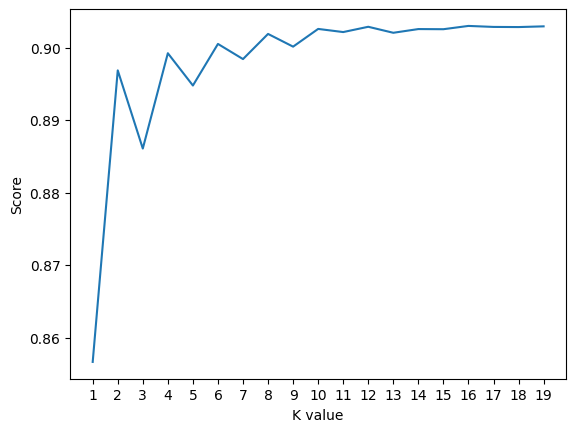

Maximum KNN Score is 90.30%


In [26]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(x_train, y_train)
prediction = knn.predict(x_test)

scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(x_train, y_train)
    scoreList.append(knn2.score(x_test, y_test))

plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.2f}%".format(acc))

In [27]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

acc = nb.score(x_test,y_test)*100
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.2f}%".format(acc))

Accuracy of Naive Bayes: 81.61%


In [28]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

acc = dtc.score(x_test, y_test)*100
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.2f}%".format(acc))

Decision Tree Test Accuracy 85.23%


In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(x_train, y_train)

acc = rf.score(x_test,y_test)*100
accuracies['Random Forest'] = acc
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))

Random Forest Algorithm Accuracy Score : 89.51%


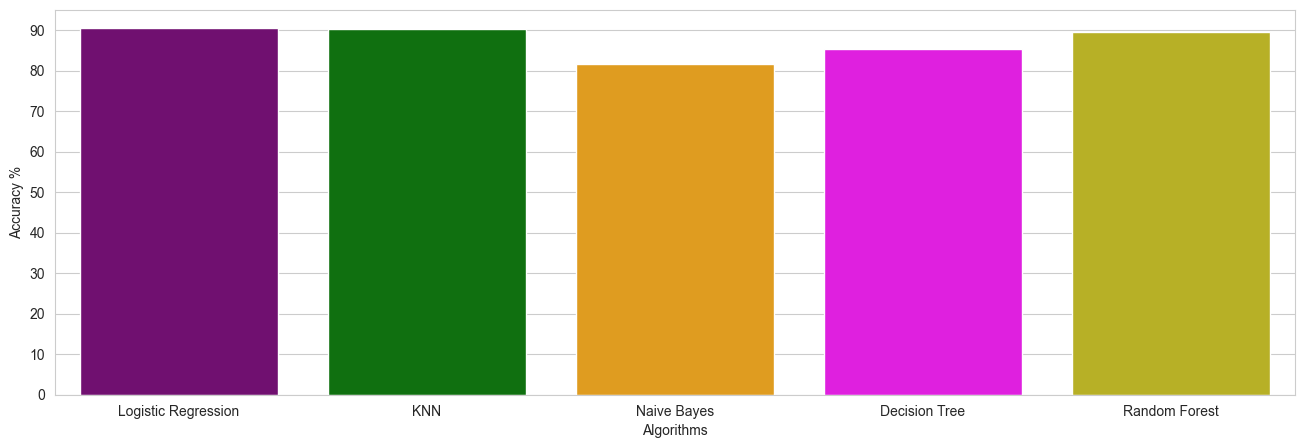

In [30]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

### Modeling

In [31]:
y_head_lr = lr.predict(x_test)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(x_train, y_train)
y_head_knn = knn3.predict(x_test)
y_head_nb = nb.predict(x_test)
y_head_dtc = dtc.predict(x_test)
y_head_rf = rf.predict(x_test)

In [32]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test,y_head_lr)
cm_knn = confusion_matrix(y_test,y_head_knn)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)

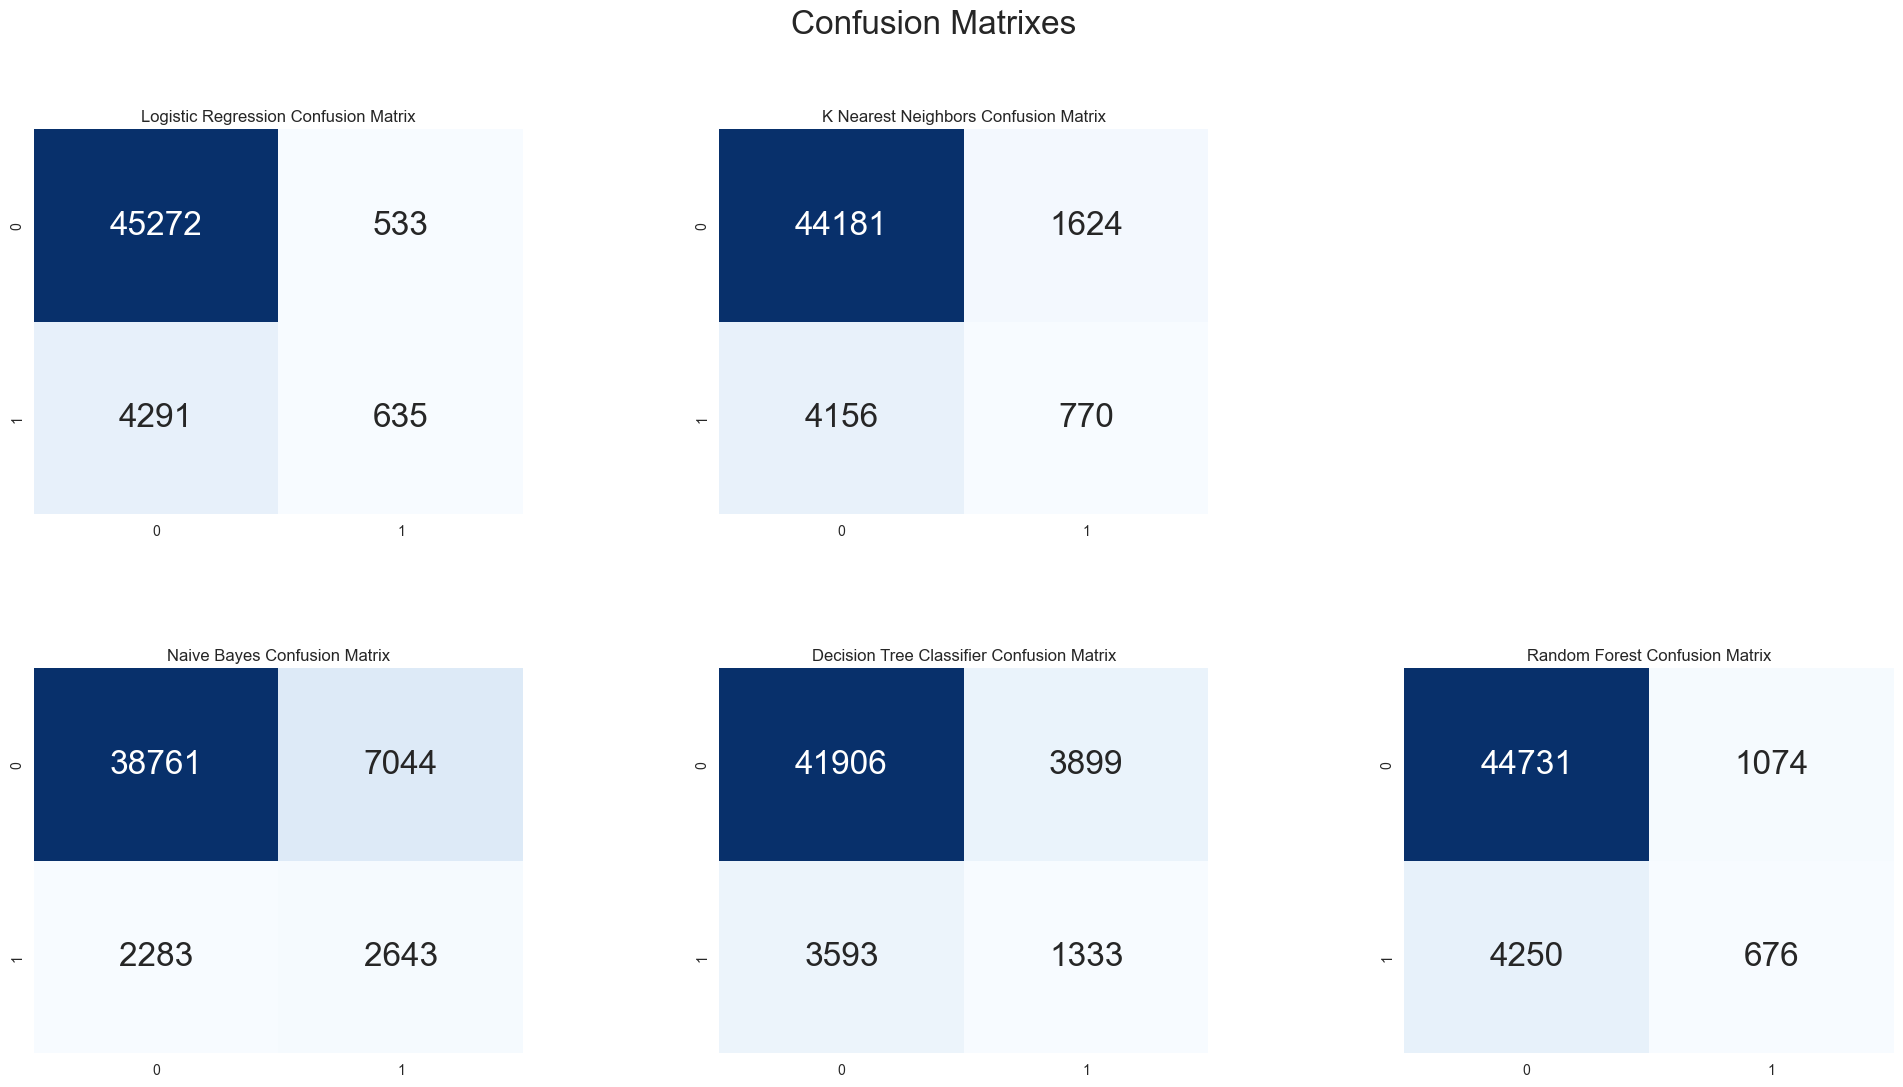

In [33]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

#### Checking the results

As we can see, most models are getting a good accuracy at the cost of only getting right the mayority class, which is the non-heart attacked people. Let's see what are the minimum percentage of people adhering to the plan for the different models:

In [50]:
len_x_test = len(x_test)
confusion_matrices = {
    "logistic_regresstion": cm_lr, 
     "knn": cm_knn, 
     "naive bates": cm_nb, 
     "decision tree": cm_dtc, 
     "random forest": cm_rf
}

In [84]:
for algorithm, conf_mat in confusion_matrices.items():
    min_ad_plan = minimum_adheresplan_prob(
            len_x_test, conf_mat[1][0] + conf_mat[1][1], 
            conf_mat[0][1]/len_x_test, 
            conf_mat[1][0]/len_x_test, 
            5*conf_mat[1][1]/len_x_test)
    print(f"The minimum adherence to the plan of the algorithm {algorithm} is {min_ad_plan}\n")

The minimum adherence to the plan of the algorithm logistic_regresstion is None

The minimum adherence to the plan of the algorithm knn is None

The minimum adherence to the plan of the algorithm naive bates is 0.9564844399749359

The minimum adherence to the plan of the algorithm decision tree is 0.5540493212683489

The minimum adherence to the plan of the algorithm random forest is None



As we can see, only with 2 models is even possible to obtain a 20% cost reduction, with a 95% and 55% adherence rate, respectively. Since this is not a great result, we will try to balance the dataset in order to obtain a better model.

### Trying to balance the dataset

In [4]:
# !pip install imblearn 
from imblearn.over_sampling import SMOTE

In [11]:
df2 = pd.read_csv("heart_disease.csv")

# The amount of missing values is not considerable enough to do a more precise cleaning
df2 = df2.dropna()
# Removing negative values from age 
df2 = df2[df2.Age > 0]
# Adding diabetes_1 and diabetes_2
df2["diabetes_1"] = df2.apply(lambda row: isDiabetes1(row), axis=1)
df2["diabetes_2"] = df2.apply(lambda row: isDiabetes2(row), axis=1)
df2 = df2.drop('Diabetes',axis=1)
df2 = df2.drop('MentHlth', axis=1)
df2 = df2.drop('PhysHlth', axis=1)
df2.tail()


,HeartAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,DiffWalk,Sex,Age,Education,Income,diabetes_1,diabetes_2
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,5.0,6.0,7.0,0.0,0.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,11.0,2.0,4.0,0.0,1.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,7.0,5.0,1.0,0.0,0.0
253679,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,9.0,6.0,2.0,0.0,1.0


In [13]:
y = df2.HeartAttack
x = df2.drop('HeartAttack', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)
print(x_train.count())
sm = SMOTE(sampling_strategy='minority', random_state=7)
oversampled_trainX, oversampled_trainY = sm.fit_resample(x_train, y_train)
print(oversampled_trainX.count())

HighBP               202922
HighChol             202922
CholCheck            202922
BMI                  202922
Smoker               202922
Stroke               202922
PhysActivity         202922
Fruits               202922
Veggies              202922
HvyAlcoholConsump    202922
GenHlth              202922
DiffWalk             202922
Sex                  202922
Age                  202922
Education            202922
Income               202922
diabetes_1           202922
diabetes_2           202922
dtype: int64
HighBP               367914
HighChol             367914
CholCheck            367914
BMI                  367914
Smoker               367914
Stroke               367914
PhysActivity         367914
Fruits               367914
Veggies              367914
HvyAlcoholConsump    367914
GenHlth              367914
DiffWalk             367914
Sex                  367914
Age                  367914
Education            367914
Income               367914
diabetes_1           367914
diabete

In [15]:
accuracies = {}

In [22]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

lr.fit(oversampled_trainX, oversampled_trainY)
acc = lr.score(x_test, y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 75.25%


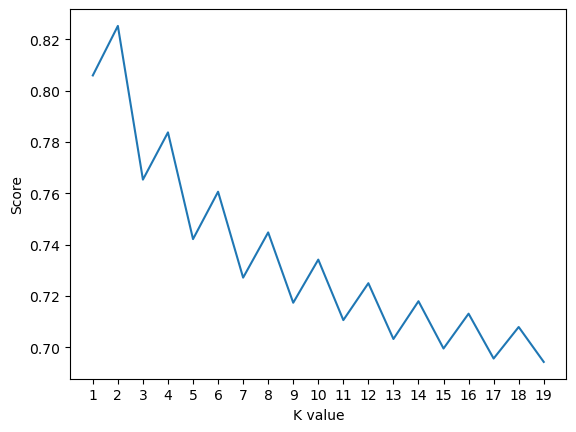

Maximum KNN Score is 82.52%


In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(oversampled_trainX, oversampled_trainY)
prediction = knn.predict(x_test)

scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(oversampled_trainX, oversampled_trainY)
    scoreList.append(knn2.score(x_test, y_test))

plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.2f}%".format(acc))

In [18]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(oversampled_trainX, oversampled_trainY)

acc = nb.score(x_test,y_test)*100
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.2f}%".format(acc))

Accuracy of Naive Bayes: 70.85%


In [19]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(oversampled_trainX, oversampled_trainY)

acc = dtc.score(x_test, y_test)*100
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.2f}%".format(acc))

Decision Tree Test Accuracy 84.97%


In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(oversampled_trainX, oversampled_trainY)

acc = rf.score(x_test,y_test)*100
accuracies['Random Forest'] = acc
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))

Random Forest Algorithm Accuracy Score : 89.15%


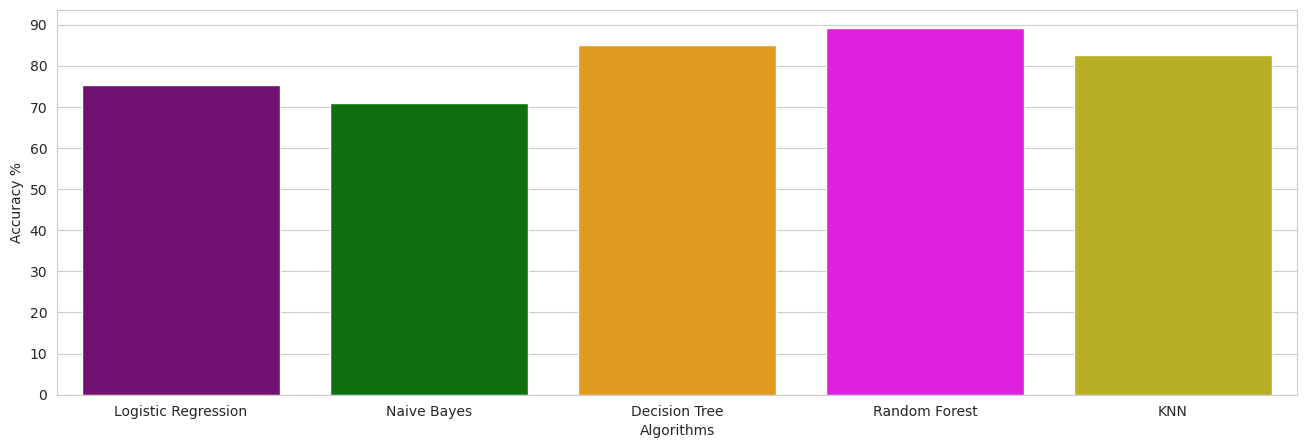

In [23]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

In [27]:
y_head_lr = lr.predict(x_test)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(oversampled_trainX, oversampled_trainY)
y_head_knn = knn3.predict(x_test)
y_head_nb = nb.predict(x_test)
y_head_dtc = dtc.predict(x_test)
y_head_rf = rf.predict(x_test)

In [28]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test,y_head_lr)
cm_knn = confusion_matrix(y_test,y_head_knn)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)

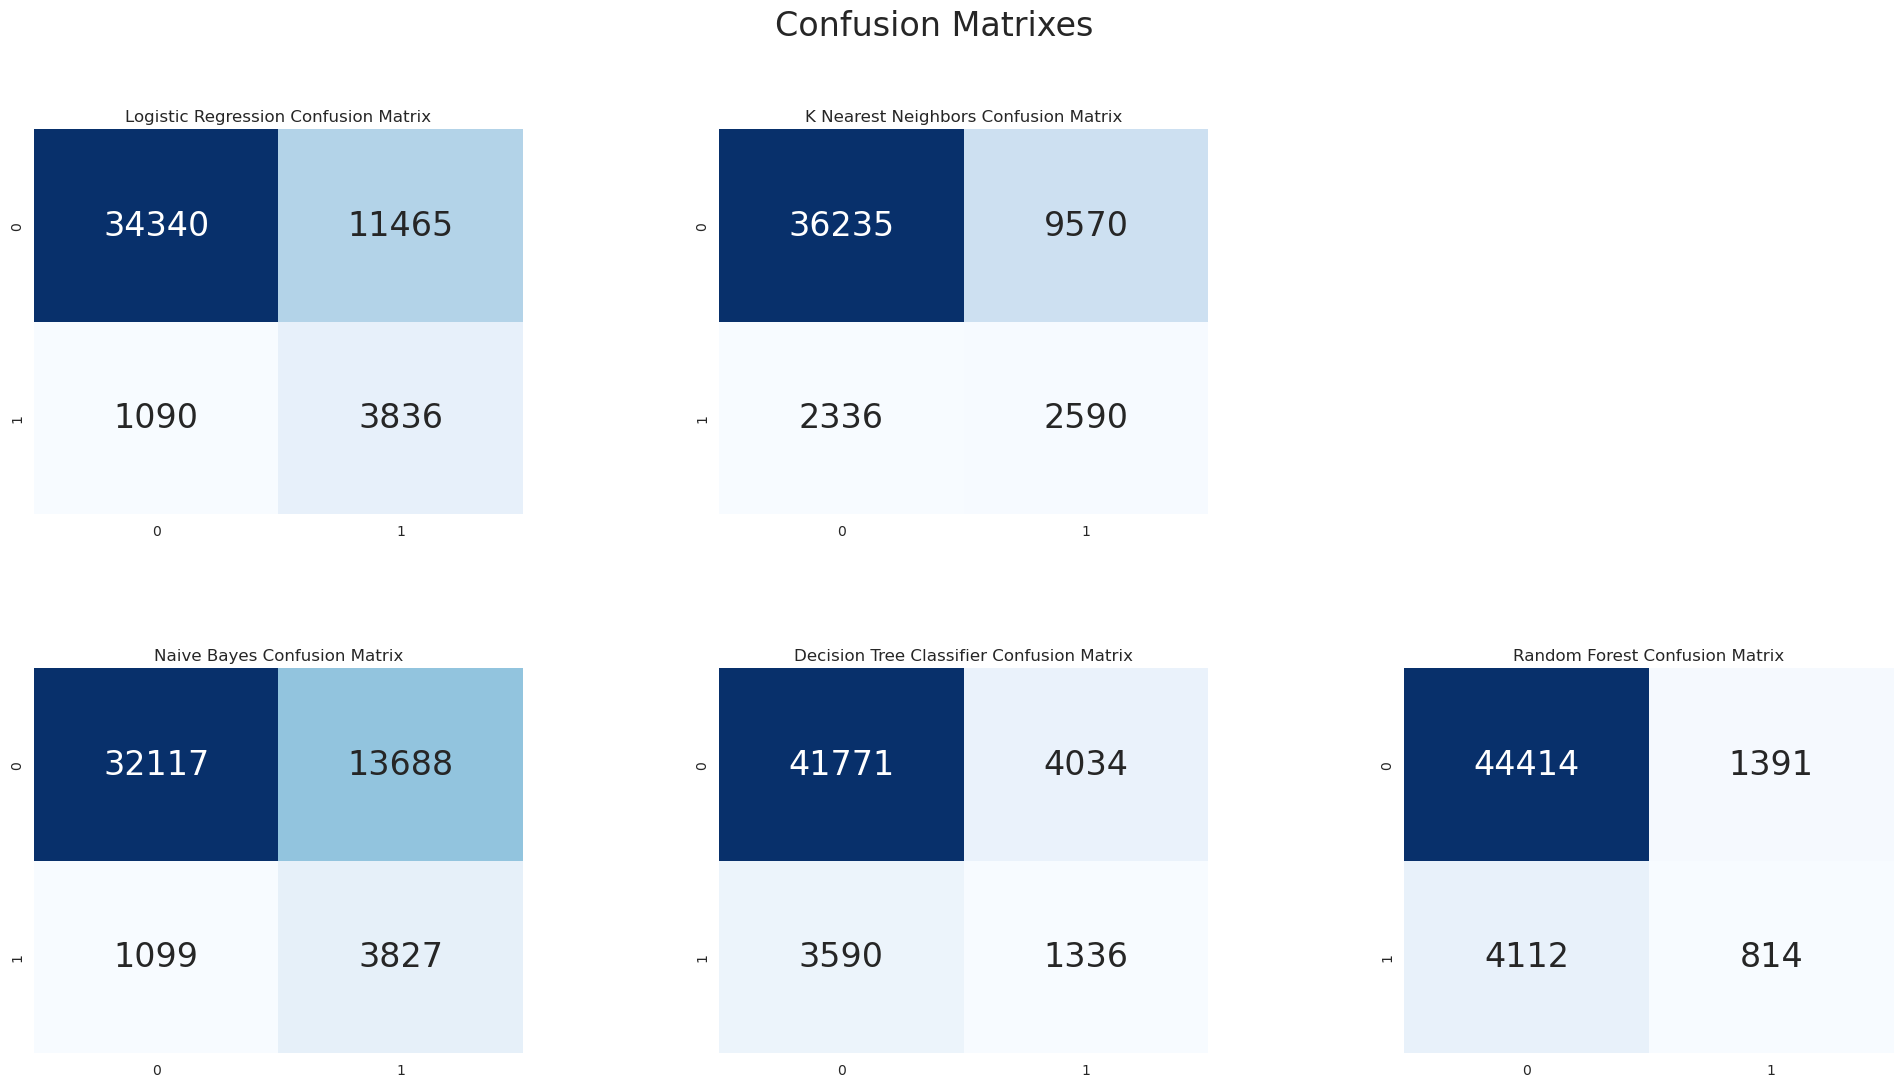

In [29]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

### Balancing with undersampling

In [1]:
from imblearn.under_sampling import RandomUnderSampler 

In [7]:
df2 = pd.read_csv("heart_disease.csv")

# The amount of missing values is not considerable enough to do a more precise cleaning
df2 = df2.dropna()
# Removing negative values from age 
df2 = df2[df2.Age > 0]
# Adding diabetes_1 and diabetes_2
df2["diabetes_1"] = df2.apply(lambda row: isDiabetes1(row), axis=1)
df2["diabetes_2"] = df2.apply(lambda row: isDiabetes2(row), axis=1)
df2 = df2.drop('Diabetes',axis=1)
df2 = df2.drop('MentHlth', axis=1)
df2 = df2.drop('PhysHlth', axis=1)
df2.tail()

,HeartAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,DiffWalk,Sex,Age,Education,Income,diabetes_1,diabetes_2
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,5.0,6.0,7.0,0.0,0.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,11.0,2.0,4.0,0.0,1.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,5.0,2.0,0.0,0.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,1.0,7.0,5.0,1.0,0.0,0.0
253679,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,9.0,6.0,2.0,0.0,1.0


In [100]:
y = df2.HeartAttack
x = df2.drop('HeartAttack', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=0)

In [117]:
from collections import Counter
rus = RandomUnderSampler(random_state=123)
x_train_rus, y_train_rus= rus.fit_resample(x_train, y_train)
print(sorted(Counter(y_train_rus).items()))

[(0.0, 18965), (1.0, 18965)]


In [118]:
accuracies = {}

In [119]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

lr.fit(x_train_rus, y_train_rus)
acc = lr.score(x_test, y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

Test Accuracy 75.08%


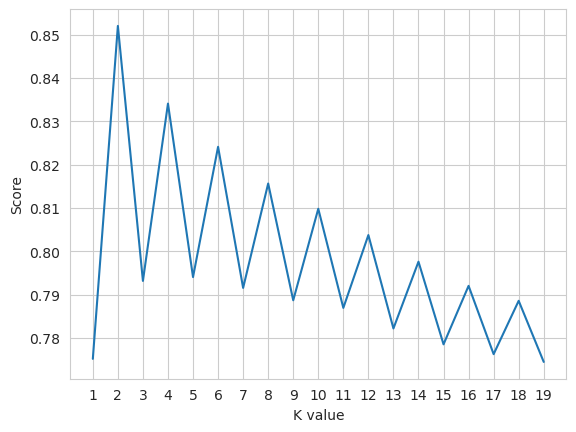

Maximum KNN Score is 85.20%


In [120]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(x_train_rus, y_train_rus)
prediction = knn.predict(x_test)

scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(x_train_rus, y_train_rus)
    scoreList.append(knn2.score(x_test, y_test))

plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
accuracies['KNN'] = acc
print("Maximum KNN Score is {:.2f}%".format(acc))

In [121]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train_rus, y_train_rus)

acc = nb.score(x_test,y_test)*100
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.2f}%".format(acc))

Accuracy of Naive Bayes: 74.52%


In [122]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train_rus, y_train_rus)

acc = dtc.score(x_test, y_test)*100
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.2f}%".format(acc))

Decision Tree Test Accuracy 67.98%


In [123]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 1)
rf.fit(x_train_rus, y_train_rus)

acc = rf.score(x_test,y_test)*100
accuracies['Random Forest'] = acc
print("Random Forest Algorithm Accuracy Score : {:.2f}%".format(acc))

Random Forest Algorithm Accuracy Score : 72.04%


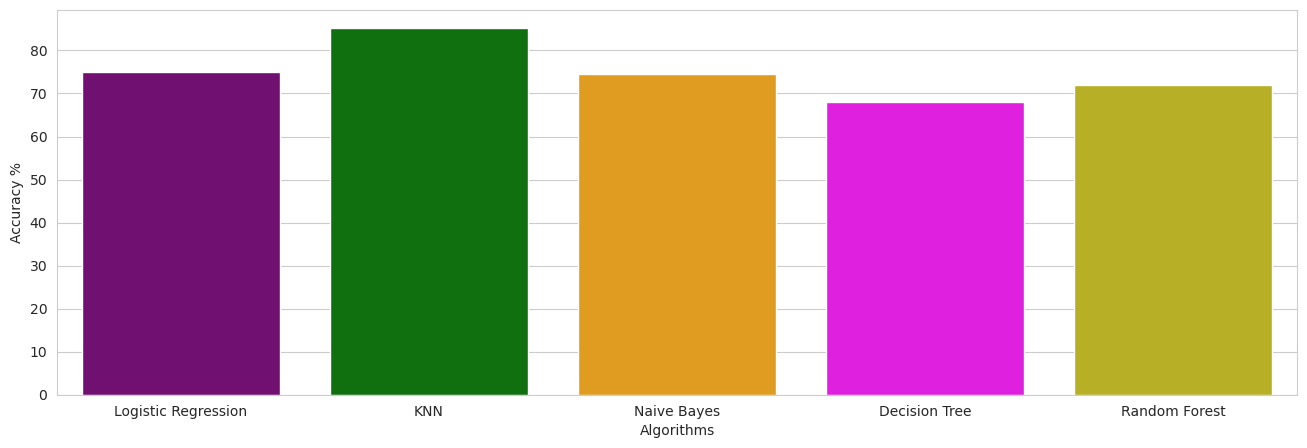

In [124]:
colors = ["purple", "green", "orange", "magenta","#CFC60E","#0FBBAE"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

In [125]:
y_head_lr = lr.predict(x_test)
knn3 = KNeighborsClassifier(n_neighbors = 2)
knn3.fit(x_train_rus, y_train_rus)
y_head_knn = knn3.predict(x_test)
y_head_nb = nb.predict(x_test)
y_head_dtc = dtc.predict(x_test)
y_head_rf = rf.predict(x_test)

In [126]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test,y_head_lr)
cm_knn = confusion_matrix(y_test,y_head_knn)
cm_nb = confusion_matrix(y_test,y_head_nb)
cm_dtc = confusion_matrix(y_test,y_head_dtc)
cm_rf = confusion_matrix(y_test,y_head_rf)

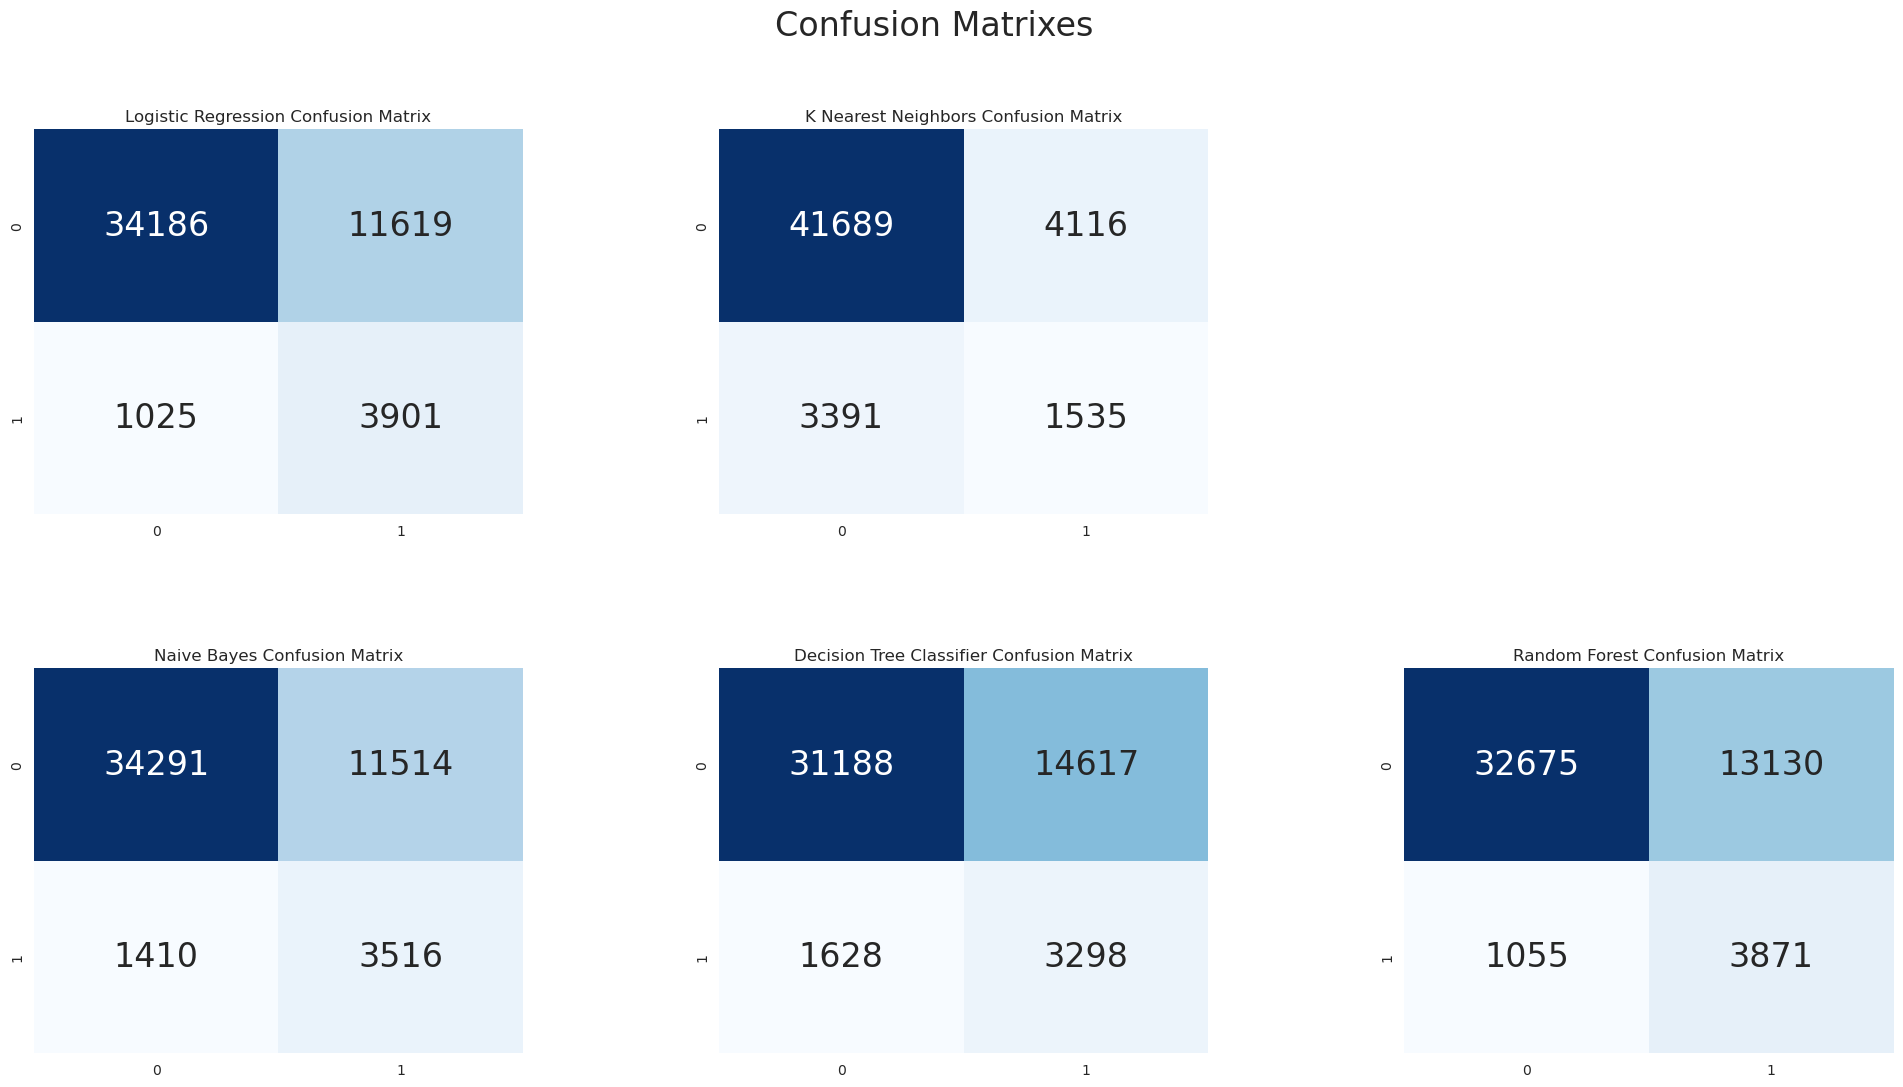

In [127]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Naive Bayes Confusion Matrix")
sns.heatmap(cm_nb,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("Decision Tree Classifier Confusion Matrix")
sns.heatmap(cm_dtc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

In [128]:
len_x_test = len(x_test)
confusion_matrices = {
    "logistic_regresstion": cm_lr, 
     "knn": cm_knn, 
     "naive bates": cm_nb, 
     "decision tree": cm_dtc, 
     "random forest": cm_rf
}

In [129]:
for algorithm, conf_mat in confusion_matrices.items():
    min_ad_plan = minimum_adheresplan_prob(
            len_x_test, conf_mat[1][0] + conf_mat[1][1], 
            conf_mat[0][1]/len_x_test, 
            conf_mat[1][0]/len_x_test, 
            5*conf_mat[1][1]/len_x_test)
    print(f"The minimum adherence to the plan of the algorithm {algorithm} is {min_ad_plan}\n")

The minimum adherence to the plan of the algorithm logistic_regresstion is None

The minimum adherence to the plan of the algorithm knn is 0.6599079675493016

The minimum adherence to the plan of the algorithm naive bates is None

The minimum adherence to the plan of the algorithm decision tree is None

The minimum adherence to the plan of the algorithm random forest is None



## Random Forest Hyperparameter tuning

In [308]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [487]:
from sklearn.metrics import make_scorer

def minimize_adherence(y_true, y_pred):
    cm = confusion_matrix(y_test,y_head_rf)
    heart_attacks = len(y_test[y_test==1])
    total_cases = len(y_true)
    fpp = cm[0][1]/total_cases
    fnp = cm[1][0]/total_cases
    tpp = cm[1][1]/total_cases
    
    adherence =  minimum_adheresplan_prob(total_cases, heart_attacks, fpp, fnp, tpp)
    
    return adherence if (adherence > 0 and adherence < 1) else -1000

adherence_metric_func = make_scorer(minimize_adherence, greater_is_better=False)

In [488]:
param_grid = {
    'max_depth': [8, 10, 12, 14, 16],
    'max_features': [3,4,5],
    'n_estimators': [50, 100, 150, 200],
    'class_weight': ['balanced', 'balanced_subsample', {0:1,1:20}, {0:1,1:50}, {0:1,1:100}]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1, verbose = 2,
                          scoring={'recall': 'recall', 
                                   'f1_weighted':'f1_weighted', 
                                   'adherence': adherence_metric_func},
                          refit='adherence')

grid_search.fit(x_train, y_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', 'balanced_subsample',
                                          {0: 1, 1: 20}, {0: 1, 1: 50},
                                          {0: 1, 1: 100}],
                         'max_depth': [8, 10, 12, 14, 16],
                         'max_features': [3, 4, 5],
                         'n_estimators': [50, 100, 150, 200]},
             refit='adherence',
             scoring={'adherence': make_scorer(minimize_adherence, greater_is_better=False),
                      'f1_weighted': 'f1_weighted', 'recall': 'recall'},
             verbose=2)

In [494]:
grid_search.best_score_

-0.5186251914338078

In [495]:
grid_search.best_params_

{'class_weight': 'balanced',
 'max_depth': 8,
 'max_features': 3,
 'n_estimators': 50}

In [496]:
y_head_rf = grid_search.best_estimator_.predict(x_test)
cm_rf = confusion_matrix(y_test,y_head_rf)
cm_rf

array([[32911, 12894],
       [  934,  3992]])

In [497]:
y_head_rf = grid_search.best_estimator_.predict(x_test)
cm_rf = confusion_matrix(y_test,y_head_rf)
min_ad_plan = minimum_adheresplan_prob(
            len(x_test), cm_rf[1][0] + cm_rf[1][1], 
            cm_rf[0][1]/len(x_test), 
            cm_rf[1][0]/len(x_test), 
            cm_rf[1][1]/len(x_test))
print(f"The minimum adherence to the plan is {min_ad_plan}\n")

The minimum adherence to the plan is 0.5151259381508114



In [498]:
minimize_adherence(y_test, y_head_rf)

0.5151259381508114

In [499]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

In [500]:
accuracy_score(y_test, y_head_rf)

0.7274250458299659

In [503]:
recall_score(y_test, y_head_rf)

0.8103938286642306

In [502]:
accuracy_score(y_test, y_head_rf, average='weighted')

0.7274250458299659